# Lab 09 - Support Vector Machines

In [2]:
# You may need these
import matplotlib.pyplot as plt 
import seaborn as sb
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
import sklearn.svm as svm

import matplotlib.pyplot as plt
%matplotlib inline

# Make a classical example data set

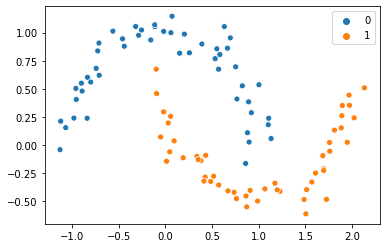

In [3]:
# Use sklearn's make_moon to make a clasical nonlinear classification example
X,y=make_moons(n_samples=100,noise=0.1)
sb.scatterplot(X[:,0],X[:,1],hue=y)

# Linear SVMs

In [4]:
# make a linear SVM and fit it
S = svm.SVC(C=0.1,kernel='linear')
S.fit(X,y)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [5]:
# Get the training accuracy for the SVM
yp=S.predict(X)
np.sum(y==yp)/y.shape[0]

0.84

In [ ]:
S.support_ # Array of the indices of the training examples that are support vectors

S.support_vectors_ #x,y of the training examples that are support vectors

S.decision_function(X) # Probabilities... if >0, then 1.. If <0 then 0

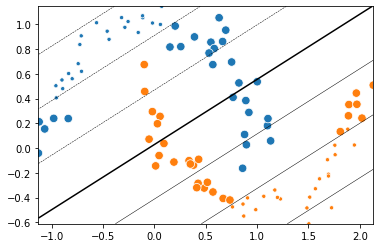

In [6]:
# Visualize the decision function and support vectors
# Look up what a meshgrid is later
def plotSVMfit(S,X,y):
    
    # Make a countour map of the decision function 
    # generate a meshgrid 
    numbins = 20
    x1 = np.linspace(X[:,0].min(),X[:,0].max(), numbins)
    x2 = np.linspace(X[:,1].min(),X[:,1].max(), numbins)
    X1, X2 = np.meshgrid(x1, x2)

    # Now get the decision function into the same format
    XX=np.c_[X1.reshape(-1,1),X2.reshape(-1,1)]
    YY=S.decision_function(XX)
    Y = YY.reshape((numbins,numbins))
    
    # Determine the levels we want to plot + width of lines 
    ymax = np.abs(Y).max()
    lev = np.linspace(-1,1,9)*ymax
    levWidth = np.array([1,1,1,1,3,1,1,1,1])/2

    # Figure out the suppport vectos 
    alpha = y*0
    alpha[S.support_]=1 # np.abs(S.dual_coef_)
    
    sb.scatterplot(X[:,0],X[:,1],hue=y,size=alpha+1,legend=False)
    plt.contour(X1,X2,Y,levels=lev,colors='black',linewidths=levWidth)

S = svm.SVC(C=0.1,kernel='linear') # As you increase C, margins will get tighter but only until a certain point
S.fit(X,y)
plotSVMfit(S,X,y)

# Different lines = different thresholds

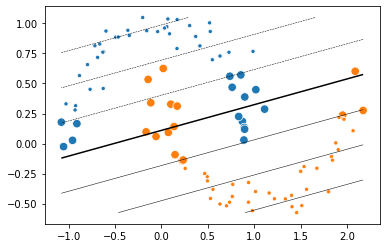

In [6]:
# Do a stricter C 
S = svm.SVC(C=10,kernel='linear')
S.fit(X,y)
plotSVMfit(S,X,y)

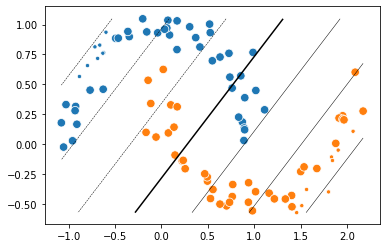

In [7]:
# Do a more lenient C 
S = svm.SVC(C=0.02,kernel='linear')
S.fit(X,y)
plotSVMfit(S,X,y)

## Nonlinear Kernels

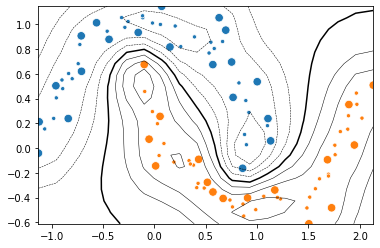

In [14]:
# Now let's try differnet nonlinear kernels 
# Play around widely with C + gamma 
# Gamma is 1/variance of the kernel
# What Determines the "smoothness" of the decision boundary? 
S = svm.SVC(C=10,kernel='rbf',gamma=10) #radial basis function, its like a heat map
S.fit(X,y)
plotSVMfit(S,X,y)

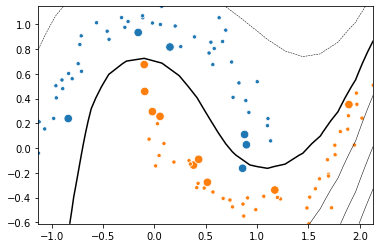

In [13]:
# Polynomial kernel 
# degree = polynomial degree 
# coef0 = include constant term into the polynomial (all lower order terms)
S = svm.SVC(C=0.2,kernel='poly',degree=5,coef0=True)
S.fit(X,y)
plotSVMfit(S,X,y)

## Evaluation using crossvalidation 

In [16]:
scoring = ['accuracy']
S = svm.SVC(C=1,kernel='rbf',gamma=1)
scores = cross_validate(S, X, y, scoring=scoring,cv=10, return_train_score=True) #Another version of cross_val_score but sklearn's
print(f"accuracy: {scores['test_accuracy'].mean()}")

accuracy: 0.9800000000000001


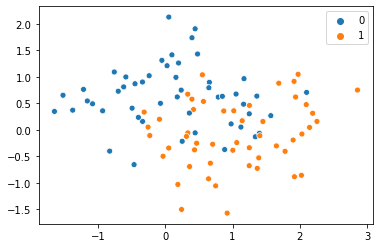

In [11]:
# Make a harder data set 
X,y=make_moons(n_samples=100,noise=0.5)
sb.scatterplot(X[:,0],X[:,1],hue=y)

accuracy: 0.76


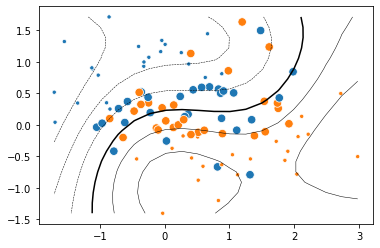

In [12]:
# Now repear the cross validated accuracy
X,y=make_moons(n_samples=100,noise=0.5)
S = svm.SVC(C=10,kernel='rbf',gamma=0.2)
S.fit(X,y)
plotSVMfit(S,X,y)
scoring = ['accuracy']
scores = cross_validate(S, X, y, scoring=scoring,cv=10, return_train_score=True)
print(f"accuracy: {scores['test_accuracy'].mean()}")

## Parameter tuning using gridsearch

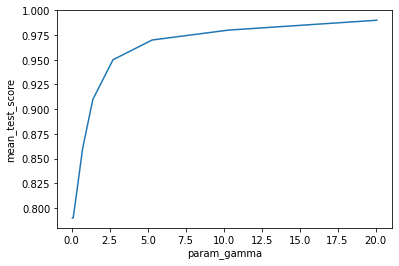

In [18]:
S = svm.SVC(C=0.1,kernel='rbf',gamma=8)
gamma =np.exp(np.linspace(-3,3,10))
param_grid = {'gamma': gamma}
scoring={'accuracy':make_scorer(accuracy_score)}
gscv = GridSearchCV(S, param_grid=param_grid, cv = 5)
gscv.fit(X, y)
res = pd.DataFrame(gscv.cv_results_)
sb.lineplot(data=res,x='param_gamma',y='mean_test_score')

## Unbalanced example 

In [14]:
# Read the Example file 
D=pd.read_csv('example.csv')

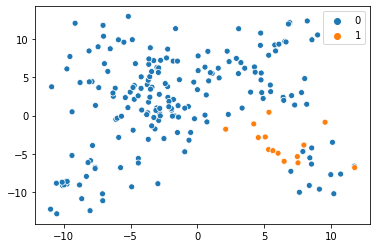

In [15]:
# Put into numpy arrays and plot 
X=np.c_[D.x1,D.x2]
y=D.y.values
sb.scatterplot(X[:,0],X[:,1],hue=y)

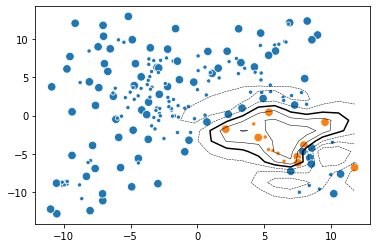

In [16]:
# What type of SVM do we need to use to fit this? 
S = svm.SVC(C=10,kernel='rbf',gamma=0.2)
S.fit(X,y)
plotSVMfit(S,X,y)

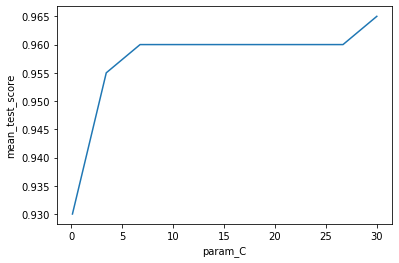

In [17]:
#Now let's tune C to see where we get the best crossvalidted accuracy 
S = svm.SVC(C=0.1,kernel='rbf',gamma=0.2)
C_grid = (np.linspace(0.1,30,10))
param_grid = {'C': C_grid}
scoring={'accuracy':make_scorer(accuracy_score)}
gscv = GridSearchCV(S, param_grid=param_grid, cv = 5)
gscv.fit(X, y)
res = pd.DataFrame(gscv.cv_results_)
sb.lineplot(data=res,x='param_C',y='mean_test_score')

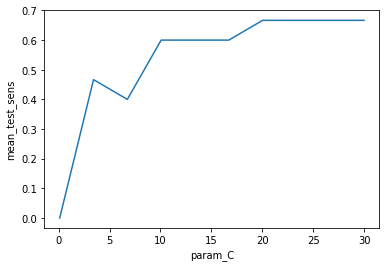

In [18]:
#What about specificity and sensitivity? 
# In case your metric does not exist in sklearn
# you can define it yourself 
def specificity_score(y,yhat):
    TN = np.logical_and(y==0,yhat==0).sum()
    FP = np.logical_and(y==0,yhat==1).sum()
    return TN/(TN+FP)

def sensitivity_score(y,yhat):
    TP = np.logical_and(y==1,yhat==1).sum()
    FN = np.logical_and(y==1,yhat==0).sum()
    return TP/(TP+FN)

# Now evaluat on both metric 
S = svm.SVC(C=0.1,kernel='rbf',gamma=0.05)
C_grid = (np.linspace(0.1,30,10))
param_grid = {'C': C_grid}
scoring={'spec':make_scorer(specificity_score),
        'sens':make_scorer(sensitivity_score)}
gscv = GridSearchCV(S, param_grid=param_grid, cv = 5,scoring=scoring,refit='sens')
gscv.fit(X, y)
res = pd.DataFrame(gscv.cv_results_)
sb.lineplot(data=res,x='param_C',y='mean_test_sens')

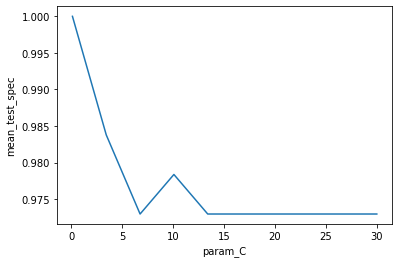

In [19]:
sb.lineplot(data=res,x='param_C',y='mean_test_spec')